In [16]:
# Core
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
from tqdm import tqdm

# Scikit-learn: data handling & preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Scikit-learn: metrics & calibration
from sklearn.metrics import brier_score_loss, r2_score,mean_squared_error
from sklearn.calibration import calibration_curve

# Scikit-learn: models (regression)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Scikit-learn: models (classification / propensity)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# Gradient boosting libraries (optional; install if needed)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Reproducibility
random_seed = 42  # do not change


In [17]:
data = pd.read_csv("loaded_student_data_2018.csv")

In [18]:
data = data.drop(columns=['dishwasher','stu_wgt', 'car', 'computer_n', 'television','science', 'read', 'math','year','school_id','student_id','wealth'])

#### computing propensity score and trimming the data with scores out the range [0.05-0.95]

In [19]:
# Randomize treatment: simulate a world with no relationship between X and T
np.random.seed(42)
T = data['computer']  # Binary treatment: 1 = has computer, 0 = no
y = np.random.uniform(low=70, high=840, size=len(data))  # Match scale of achievement scores

# Define confounders (exclude country, T, and Y)
excluded_cols = ['achievement', 'computer','internet']  # internet is a mediator
confounders = [col for col in data.columns if col not in excluded_cols]
X = data[confounders]

In [20]:
# Train-validation split
X_train, X_val, T_train, T_val, y_train, y_val = train_test_split(X, T, y, test_size=0.3, random_state=42)


#### Multi propensity scores model check


=== Training and Evaluating: Logistic Regression CV ===
****************************************************************************************************
LogisticRegressionCV - Brier Score: 0.0980


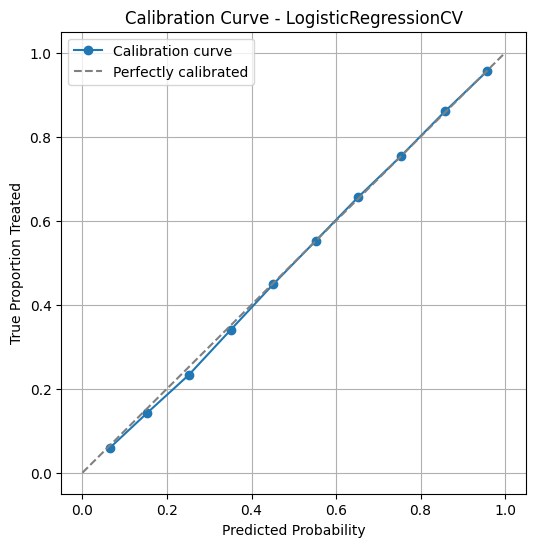

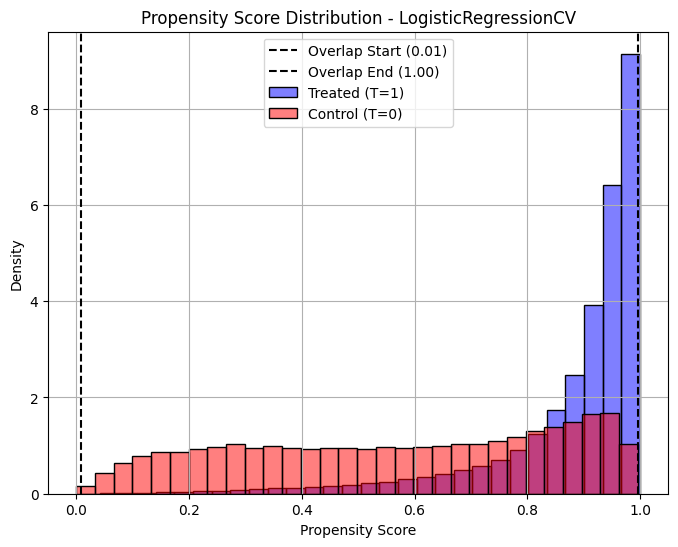

In [22]:
def train_propensity_model(model, X_train, T_train):
    return model.fit(X_train, T_train)

def eval_propensity_model(fitted_model, X_val, T_val):
    model_name = fitted_model.__class__.__name__
    T_probs = fitted_model.predict_proba(X_val)[:, 1]
    brier = brier_score_loss(T_val, T_probs)
    print("*" * 100)
    print(f"{model_name} - Brier Score: {brier:.4f}")
    prob_true, prob_pred = calibration_curve(T_val, T_probs, n_bins=10)
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Proportion Treated')
    plt.title(f'Calibration Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def check_overlap(propensity_model, X_train, T_train):
    propensity_scores = propensity_model.predict_proba(X_train)[:, 1]
    treated_scores = propensity_scores[T_train == 1]
    control_scores = propensity_scores[T_train == 0]
    overlap_lower = max(treated_scores.min(), control_scores.min())
    overlap_upper = min(treated_scores.max(), control_scores.max())
    plt.figure(figsize=(8, 6))
    sns.histplot(treated_scores, bins=30, color='blue', label='Treated (T=1)', stat='density', alpha=0.5)
    sns.histplot(control_scores, bins=30, color='red', label='Control (T=0)', stat='density', alpha=0.5)
    plt.axvline(x=overlap_lower, color='black', linestyle='--', label=f'Overlap Start ({overlap_lower:.2f})')
    plt.axvline(x=overlap_upper, color='black', linestyle='--', label=f'Overlap End ({overlap_upper:.2f})')
    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.title(f'Propensity Score Distribution - {propensity_model.__class__.__name__}')
    plt.legend()
    plt.grid(True)
    plt.show()


# Set random seed
random_seed = 42

# Define model dictionary
propensity_models = {
    "Logistic Regression CV": LogisticRegressionCV(cv=5, max_iter=1000, random_state=random_seed)#,
    # "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5, random_state=random_seed),
    # "Extra Trees": ExtraTreesClassifier(n_estimators=100, random_state=random_seed),
    # "XGBoost": XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss', random_state=random_seed),
    # "CatBoost": CatBoostClassifier(iterations=100, depth=3, learning_rate=0.1, verbose=0, random_seed=random_seed),
}

# Train and evaluate all models
trained_models = {}

for name, model in propensity_models.items():
    print(f"\n=== Training and Evaluating: {name} ===")
    fitted_model = train_propensity_model(model, X_train, T_train)
    eval_propensity_model(fitted_model, X_val, T_val)
    check_overlap(fitted_model, X_train, T_train)
    trained_models[name] = fitted_model  # Save model for later use


#### trimming using best propensity score model

In [23]:

propensity_model_lg = trained_models["Logistic Regression CV"]
full_propensity_scores = propensity_model_lg.predict_proba(X)[:, 1]

#Overlap bounds
lower_bound, upper_bound = 0.05, 0.95

#Boolean mask as a pandas Series aligned to X's index
mask = (full_propensity_scores >= lower_bound) & (full_propensity_scores <= upper_bound)
mask = pd.Series(mask, index=X.index)

# Ensure T and y are pandas Series aligned with X
T_series = T if isinstance(T, pd.Series) else pd.Series(T, index=X.index, name="computer")
y_series = y if isinstance(y, pd.Series) else pd.Series(y, index=X.index, name="achievement")

# Trim
X_trimmed = X.loc[mask]
T_trimmed = T_series.loc[mask]
y_trimmed = y_series.loc[mask]
propensity_scores_trimmed = full_propensity_scores[mask.values]  # keep as ndarray or wrap as Series

print(f"Original sample size: {X.shape[0]}")
print(f"Trimmed sample size: {X_trimmed.shape[0]}")

# 6) Build a clean DataFrame and save
trimmed_data = pd.concat(
    [X_trimmed,
     T_trimmed.rename("computer"),
     y_trimmed.rename("achievement"),
     pd.Series(propensity_scores_trimmed, index=X_trimmed.index, name="propensity_score")],
    axis=1
)

# trimmed_data.to_csv("dataset_2018_Y.csv", index=False)



Original sample size: 612004
Trimmed sample size: 391320


## Estimation

In [24]:
data = trimmed_data.copy()# pd.read_csv("dataset_2018_Y.csv")
data.shape

(391320, 89)

In [37]:
# Define treatment and outcome
T = data['computer']  # Binary treatment: 1 = has computer, 0 = no
y = data['achievement']      # Outcome: average score of math, read, and science

# Define confounders (exclude country, T, and Y)
excluded_cols = ['achievement', 'computer', 'propensity_score']  # internet is a mediator
confounders = [col for col in data.columns if col not in excluded_cols]
X = data[confounders]

In [38]:
# Train-validation split
X_train, X_val, T_train, T_val, y_train, y_val = train_test_split(X, T, y, test_size=0.3, random_state=42)

### T-Learner

In [39]:
def train_t_learner(model, X_train, y_train):
    """
    Return a fitted s-learner model on your training data
    :param model:
    :param X_train:
    :param y_train:
    :return:
    """
    return model.fit(X_train, y_train)

def t_learner_model_selection(models, metric, X_train, y_train, X_val, y_val,maximize=False):
    """
    Use the validation set to select the model with the best performance over the provided metric (e.g. rmse)
    Note that X_train and y_train should only include the appropriate intervention arm's data.

    You may select models in a more complicated way (like you would in real life). But here you can simplify.
    You must either return the fitted model or show the scores that lead to your decision.
    :param models:
    :param metric:
    :param X_train:
    :param y_train:
    :param X_val:
    :param y_val:
    :param maximize: Whether to maximize or minimize the metric
    :return:
    """
    scores = {}
    fitted_models = {}


    for name, model in models.items():
        fitted_model = train_t_learner(model, X_train, y_train)
        preds = fitted_model.predict(X_val)
        score = metric(y_val, preds)
        scores[name] = score
        fitted_models[name] = fitted_model
        print(f"{name} - Score: {score:.4f}")

    # Select based on direction
    best_model_name = max(scores, key=scores.get) if maximize else min(scores, key=scores.get)
    print(f"\nBest Model: {best_model_name} (Score: {scores[best_model_name]:.4f})")

    return fitted_models[best_model_name]

In [40]:
models = {
    "LinearRegression": LinearRegression(),
    "RandomForestRegressor": RandomForestRegressor(n_estimators=300, random_state=random_seed, n_jobs=-1),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=random_seed)
}

metrics = {
    'MSE': mean_squared_error,
}

In [41]:
fitted_t_learner_1 = None
fitted_t_learner_0 = None

for name, metric in metrics.items():
    print(f"\nMetric: {name}")
    maximize = True if name == "R2" else False  # Set according to metric
    # For T=1
    print("\n" + "="*40)
    print("T-Learner Model Selection for Treatment Group: T=1")
    print("="*40)

    X_train_1 = X_train.loc[T_train == 1]
    y_train_1 = y_train.loc[T_train == 1]
    X_val_1 = X_val.loc[T_val == 1]
    y_val_1 = y_val.loc[T_val == 1]

    fitted_t_learner_1 = t_learner_model_selection(
        models,
        metric,
        X_train_1,
        y_train_1,
        X_val_1,
        y_val_1,
        maximize=maximize
    )

    # For T=0
    print("\n" + "="*40)
    print("T-Learner Model Selection for Control Group: T=0")
    print("="*40)

    X_train_0 = X_train.loc[T_train == 0]
    y_train_0 = y_train.loc[T_train == 0]
    X_val_0 = X_val.loc[T_val == 0]
    y_val_0 = y_val.loc[T_val == 0]

    fitted_t_learner_0 = t_learner_model_selection(
        models,
        metric,
        X_train_0,
        y_train_0,
        X_val_0,
        y_val_0,
        maximize=maximize
    )
    print("\n" + "="*80)


Metric: MSE

T-Learner Model Selection for Treatment Group: T=1
LinearRegression - Score: 49398.2093
RandomForestRegressor - Score: 54023.8140
GradientBoostingRegressor - Score: 49397.0791

Best Model: GradientBoostingRegressor (Score: 49397.0791)

T-Learner Model Selection for Control Group: T=0
LinearRegression - Score: 49234.8505
RandomForestRegressor - Score: 53134.9134
GradientBoostingRegressor - Score: 49223.6988

Best Model: GradientBoostingRegressor (Score: 49223.6988)



### Doubly Robust

In [42]:
def calculate_doubly_robust_ate(propensity_model, outcome_model_t1, outcome_model_t0, X, T, y):
    """
    Estimate ATE using the doubly robust estimator.
    """
    e = propensity_model.predict_proba(X)[:, 1]
    e = np.clip(e, 1e-3, 1 - 1e-3)

    mu1 = outcome_model_t1.predict(X)
    mu0 = outcome_model_t0.predict(X)

    T = np.array(T)
    y = np.array(y)

    term1 = T * (y - mu1) / e
    term2 = (1 - T) * (y - mu0) / (1 - e)
    ate_dr = np.mean(term1 - term2 + (mu1 - mu0))

    return ate_dr


In [43]:
ate_dr = calculate_doubly_robust_ate(propensity_model_lg, fitted_t_learner_1, fitted_t_learner_0, X_val, T_val, y_val)
print(f"Estimated ATE (Doubly Robust): {ate_dr:.4f}")

Estimated ATE (Doubly Robust): -0.1579


In [44]:
def doubly_robust_confidence_intervals(propensity_model, outcome_model_t1, outcome_model_t0,
                            X, T, y, n_bootstrap=1000, alpha=0.05, random_seed=42):
    """
    Bootstrap-based confidence intervals for the DR estimator.
    """
    np.random.seed(random_seed)
    dr_ate_estimates = []

    for _ in tqdm(range(n_bootstrap), desc="Bootstrapping DR ATE"):
        X_b, T_b, y_b = resample(X, T, y)
        try:
            ate = calculate_doubly_robust_ate(propensity_model, outcome_model_t1, outcome_model_t0, X_b, T_b, y_b)
            dr_ate_estimates.append(ate)
        except Exception:
            continue

    lower = np.percentile(dr_ate_estimates, 100 * alpha / 2)
    upper = np.percentile(dr_ate_estimates, 100 * (1 - alpha / 2))

    print(f"95% Confidence Interval for DR ATE: [{lower:.4f}, {upper:.4f}]")
    return lower, upper, dr_ate_estimates


In [45]:
lower, upper, dr_ates = doubly_robust_confidence_intervals(propensity_model_lg, fitted_t_learner_1, fitted_t_learner_0,
                                                X_val, T_val, y_val)

Bootstrapping DR ATE: 100%|██████████| 1000/1000 [16:54<00:00,  1.01s/it]

95% Confidence Interval for DR ATE: [-3.9659, 3.7906]


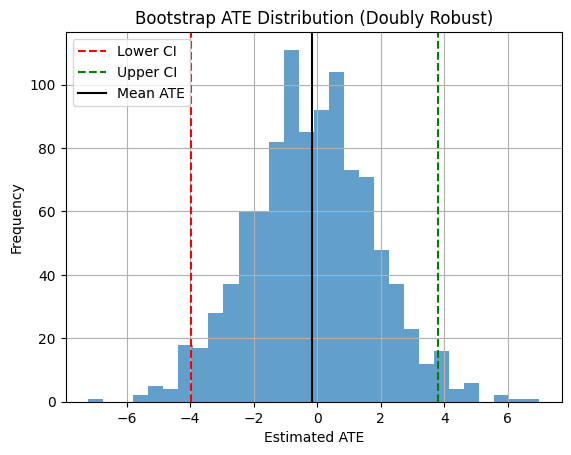

In [46]:
plt.hist(dr_ates, bins=30, alpha=0.7)
plt.axvline(lower, color='red', linestyle='--', label='Lower CI')
plt.axvline(upper, color='green', linestyle='--', label='Upper CI')
plt.axvline(np.mean(dr_ates), color='black', label='Mean ATE')
plt.title("Bootstrap ATE Distribution (Doubly Robust)")
plt.xlabel("Estimated ATE")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()